In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json
import itertools
import os
import sys
from tqdm import trange
from IPython.display import Audio

sys.path.append('../../utils')

In [2]:
desired_features = np.load('desired_features.npy')
print desired_features 

[ 0  1  6  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [3]:
from plugin_feature_extractor import PluginFeatureExtractor

np.random.seed(8)
sampleRate = 44100
overriden_parameters = [(5, 0.5), (6, 0.0), (7, 1.0), (8, 1.0)]
extractor = PluginFeatureExtractor(midi_note=24, note_length_secs=0.4,
                                   desired_features=desired_features.tolist(),
                                   overriden_parameters=overriden_parameters,
                                   render_length_secs=0.7,
                                   pickle_path="../../utils/normalisers",
                                   warning_mode="ignore",
                                   normalise_audio=False)

path = "/home/tollie/Development/vsts/synths/granulator/Builds/build-granulator-Desktop-Debug/build/debug/granulator.so"
extractor.load_plugin(path)

Successfully loaded plugin.


/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
# Get stats about resultant dataset from step size and patch size 
step_size = 0.15

(features, parameters) = extractor.get_random_normalised_example()
patch_size = len(extractor.add_patch_indices(parameters))

all_steps = []
amount = 0
mem = 0.0
while (mem <= 1.0):
    all_steps.append(mem)
    mem += step_size
    amount += 1

total_dataset_size = pow(amount, patch_size)

print "Length of tweakable params: " + str(patch_size)
print "Amount of increments per param: " + str(amount)
print "Total size of resultant dataset: " + str(total_dataset_size)

Length of tweakable params: 5
Amount of increments per param: 7
Total size of resultant dataset: 16807


In [5]:
# Create every possible patch from step size and patch size
all_patches = np.array(list(itertools.product(all_steps, repeat=patch_size)))

shape = all_patches.shape
assert shape[0] == total_dataset_size
assert shape[1] == patch_size

print shape

(16807, 5)


In [6]:
# Calculate features and spectrograms and audio and save to directory
im_width = 1
im_height = 1
all_features = []
audio_paths = []
picture_paths = []
working_directory = 'gran_tsne'

if not os.path.exists(working_directory):
    os.makedirs(working_directory)

if not os.path.exists(working_directory + '/spectrograms'):
    os.makedirs(working_directory + '/spectrograms')
    
if not os.path.exists(working_directory + '/audio'):
    os.makedirs(working_directory + '/audio')

for i in trange(len(all_patches), desc="Creating Data"):
    
    patch = extractor.partial_patch_to_patch(all_patches[i])
    patch = extractor.add_patch_indices(patch)
    all_features.append(extractor.get_features_from_patch(patch))
    
    extractor.set_patch(patch)    
    audio_name = 'audio_{:d}'.format(i)
    audio_path = working_directory + '/audio/' + audio_name + '.wav'
    audio_paths.append(audio_path)
    extractor.write_to_wav(audio_path)

    picture_name = 'spectrogram_{:d}'.format(i)
    picture_path = working_directory + '/spectrograms/' + picture_name
    picture_paths.append(picture_path + '.png')
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(im_width, im_height)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.specgram(extractor.get_audio_frames(), NFFT=512, 
                Fs=44100, noverlap=256, cmap=plt.cm.gist_heat, 
                mode='magnitude', interpolation='gaussian',
                aspect='normal')
    plt.savefig(picture_path)
    plt.close()

Creating Data:   0%|          | 0/16807 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:7224: RuntimeWarning: divide by zero encountered in log10
  Z = 20. * np.log10(spec)
/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The normal aspect was deprecated in version 1.2. Use auto instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
Creating Data: 100%|██████████| 16807/16807 [51:21<00:00,  5.46it/s]  


In [7]:
all_features = np.array(all_features)
print all_features.shape

(16807, 27, 16)


In [8]:
# Write parameters and features to file
np.save(working_directory + "/all_features.npy", all_features)
np.save(working_directory + "/all_patches.npy", all_patches)

In [30]:
# Calculate t-SNE
flattened = all_features.shape[1] * all_features.shape[2]
features = all_features.reshape(-1, flattened)
model = TSNE(n_components=3, learning_rate=1500, perplexity=200, 
             verbose=2, angle=0.6).fit_transform(features)

assert all_features.shape[0] == all_patches.shape[0] == len(picture_paths) == len(audio_paths) == model.shape[0]

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 16807
[t-SNE] Computed conditional probabilities for sample 2000 / 16807
[t-SNE] Computed conditional probabilities for sample 3000 / 16807
[t-SNE] Computed conditional probabilities for sample 4000 / 16807
[t-SNE] Computed conditional probabilities for sample 5000 / 16807
[t-SNE] Computed conditional probabilities for sample 6000 / 16807
[t-SNE] Computed conditional probabilities for sample 7000 / 16807
[t-SNE] Computed conditional probabilities for sample 8000 / 16807
[t-SNE] Computed conditional probabilities for sample 9000 / 16807
[t-SNE] Computed conditional probabilities for sample 10000 / 16807
[t-SNE] Computed conditional probabilities for sample 11000 / 16807
[t-SNE] Computed conditional probabilities for sample 12000 / 16807
[t-SNE] Computed conditional probabilities for sample 13000 / 16807
[t-SNE] Computed conditional probabilities

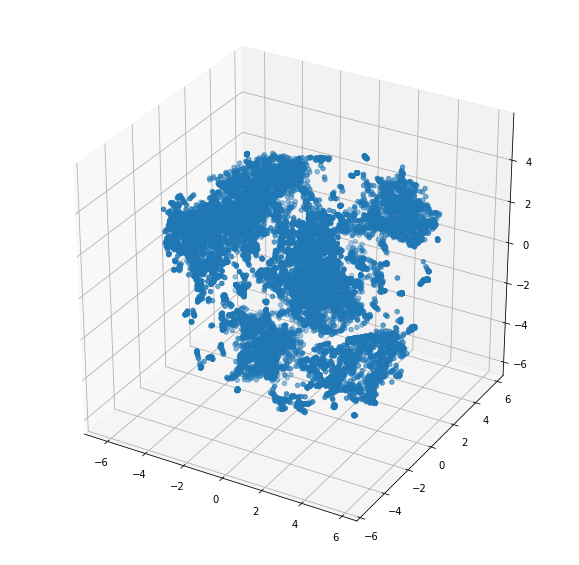

In [31]:
x = model[:,0]
y = model[:,1]
z = model[:,2]

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

In [32]:
# Create JSON so ofx / JUCE explore patches dynamically
def norm(array):
    """ Quickly normalise coordinate arrays using this method."""
    return (array - np.min(array)) / (np.max(array) - np.min(array))

x_norm = norm(x)
y_norm = norm(y)
z_norm = norm(z)

data = [{
            "spec_path": s,
            "audio_path": a,
            "patch": " ".join(str(pa) for pa in p),
            "x": x,
            "y": y,
            "z": z
        } for s, a, p, x, y, z in zip(picture_paths, audio_paths, 
                                      all_patches.tolist(), 
                                      x_norm.tolist(), y_norm.tolist(),
                                      z_norm.tolist())]

In [33]:
# Save JSON file to working directory
tsne_path = working_directory + "/gran_tsne.json"
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved %s to disk!" % tsne_path)

saved gran_tsne/gran_tsne.json to disk!
